
# Environment setup

### Import libraries

In [ ]:


import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, Sequential
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
import math
from PIL import Image
import os
import pickle
import copy
import cv2
import random
from google.colab import drive
from datetime import datetime
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import tensorflow_hub as hub
import tensorboard
from datetime import datetime
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as A
from scipy.stats import rankdata
import scipy
! pip install tensorflow_addons
import tensorflow_addons as tfa
from tqdm import tqdm

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-70vh505v
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-70vh505v
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=ebb70551dbd48ea7fd7b6b2218059a72d1512a55b45446eb6cb04c57a4fb465d
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7nrtkbr/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


## Mount google drive

In [ ]:
# Mount your Drive to the Colab VM.
drive.mount('/content/drive',force_remount=True)
path_data = '/content/drive/MyDrive/DLOD/grasp_share/Alan/20210531_grasp_dataset_ver3/'

Mounted at /content/drive


## Define utility functions

In [ ]:
def preprocessImg(images, height =224,width=224):
  images_arr_resize =  tf.image.resize(images, [width, width])
  images_arr_resize_nor= images_arr_resize/255
  return images_arr_resize_nor


def draw_centroid(imagesIn,labels):
  xy= [int(labels[0]),int(labels[1])]
  cpt = tuple(xy)
  images = copy.deepcopy(imagesIn)
  cv2.circle(images, cpt, radius=5, color=(0, 0, 255), thickness=-1)
  cv2.destroyAllWindows()
  return images
  

def picture2array(path_file):
  img = Image.open(path_file)
  arr= np.asarray(img)
  return arr

def text2array(path_file,nline = 4):
  text= np.loadtxt(path_file)
  return text[:nline]

def datafolder2pickle(path_folder, format ='.png'):
  images_arr = []
  labels_arr=[]

  files = os.listdir(path_folder)
  #print(files)
  #break

  for j in range(len(files)):

    img_path = path_folder+files[j]
    if img_path.endswith(format):
      try:
        label_path = img_path.replace(format,'.txt')
        img_arr = picture2array(img_path)
        #print(label_path)
        label_arr= text2array(label_path,nline = 4)

        images_arr.append(img_arr)
        labels_arr.append(label_arr)
      except:
        print(img_path+' has an label file issue ')  

  return np.array(images_arr), np.array(labels_arr)


def convert_to_froze_graph(keras_model, model_name, output_folder):
    """
    Export keras model to frozen model.

    Args:
        keras_model (tensorflow.python.keras.models.Model):
        model_name (str): Model name for the file name.
        output_folder (str): Output folder for saving model.

    """
    full_model = tf.function(lambda x: keras_model(x))
    full_model = full_model.get_concrete_function(
        tf.TensorSpec(keras_model.inputs[0].shape, keras_model.inputs[0].dtype)
    )

    frozen_func = convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()

    print(f"Model inputs: {frozen_func.inputs}")
    print(f"Model outputs: {frozen_func.outputs}")

    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                      logdir=output_folder,
                      name=model_name,
                      as_text=False)


def AngleBtw2Points(pointA, pointB):
  changeInX = pointB[0] - pointA[0]
  changeInY = pointB[1] - pointA[1]
  return degrees(atan2(changeInY,changeInX)) #remove degrees if you want your answer in radians


def PreprocessLabel(labels, width_xaxis, height_yaxis, width_box_max, height_box_max, angle_max ):
  labels_arr_flatten =labels # for cornell

  if labels.shape[1] == 8:
    labels_arr_flatten_nor= np.multiply(labels_arr_flatten, 
                                        [
                                        1/width_xaxis,1/height_yaxis, 
                                        1/width_box_max,1/height_box_max,
                                        1/angle_max,
                                        1,1,1
                                         ])
  else:
    labels_arr_flatten_nor= np.multiply(labels_arr_flatten, 
                                        [
                                        1/width_xaxis,1/height_yaxis, 
                                        1/width_xaxis,1/height_yaxis, 
                                        1/width_xaxis,1/height_yaxis, 
                                        1/width_xaxis,1/height_yaxis, 
                                        1,1,1
                                        ])
    
  labels_arr_flatten_nor_tf= tf.constant(labels_arr_flatten_nor)
  return labels_arr_flatten_nor_tf


def InvNorLabel(labels, width_xaxis, height_yaxis, width_box_max, height_box_max, angle_max):
  if labels.shape[1] == 8:
    labels_mul = np.multiply(labels,[
                             width_xaxis,height_yaxis,
                             width_box_max,height_box_max,
                             angle_max,
                             1,1,1
                             ])
  else:
    labels_mul = np.multiply(labels,[
                             width_xaxis,height_yaxis,
                             width_xaxis,height_yaxis,
                             width_xaxis,height_yaxis,
                             width_xaxis,height_yaxis,
                             1,1,1
                             ])
  return labels_mul


def draw_bounding_boxes(imageIn,label, option=''):
  img = copy.deepcopy(imageIn)
  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 1
  thickness= 2
  color = (0,176,80)
  size = 7
  pt_txt = tuple([50,50])
  
  #==========================OLD DRAWING FUNCTION FOR YOLO LABEL===============================
  
  if label.shape[0]==8 and option!='box':
    """
    xy= [int(label[0]),int(label[1])]
    cpt = tuple(xy)
    wpt = tuple( [int(cpt[0]+label[2]),int(cpt[1])])
    hpt = tuple( [int(cpt[0]),int(cpt[1]+label[3])])

    theta = math.radians(label[4])
   
    wx1 = wpt[0] - cpt[0]
    wy1 = wpt[1] - cpt[1]
    wx2 = 1 *(wx1*np.cos(theta) - wy1*np.sin(theta))  # the theta is counter clockwise in the 2D rotational matrix,but is clockwise in the image
    wy2 = 1 *(wx1*np.sin(theta) + wy1*np.cos(theta) )
    wpt = tuple( [ int(wx2)+ cpt[0] , int(wy2)+ cpt[1]])

    hx1 = hpt[0] - cpt[0]
    hy1 = hpt[1] - cpt[1]
    hx2 = 1 *(hx1*np.cos(theta) - hy1*np.sin(theta) )
    hy2 = 1 *(hx1*np.sin(theta) + hy1*np.cos(theta) )
    hpt = tuple( [ int(hx2)+ cpt[0] , int(hy2)+ cpt[1]])

    cv2.circle(img, cpt, radius=5, color=(0, 0, 255), thickness=-1)
    cv2.line(img, cpt, wpt, (0,0,255) , 3, )
    cv2.line(img, cpt, hpt, (0,0,255) , 3)
    """
    label_class = str(np.argmax(label[5:])+1)
    #=============================NEW DRAWING FUNCTION CREATED IN 9/6/2021 ====================
    npt=[]
    cpt = tuple([label[0],label[1]])
    pt=[tuple([label[0]-label[2] , label[1]- label[3]]), tuple([label[0]-label[2], label[1]+ label[3]])
    ,tuple([label[0]+label[2] , label[1]+ label[3]]),
    tuple([label[0]+label[2] , label[1]- label[3]])]
    theta = math.radians(label[4])

    for i in range(len(pt)):
      dx=pt[i][0]-cpt[0]
      dy=pt[i][1]-cpt[1]
      ptx=1 *(dx*np.cos(theta) - dy*np.sin(theta))
      pty=1 *(dx*np.sin(theta) + dy*np.cos(theta))
      npt.append([int(ptx+cpt[0]),int(pty+cpt[1])])

    npt=np.array(npt)
    cv2.drawContours(img,[npt],-1,(255,215,0),3)

    #cv2.putText(img,label_class, pt_txt, font, fontScale, color ,thickness, size)


  elif label.shape[0]== 11 or option=='box':
    if option!='box':
      label_class = str(np.argmax(label[8:])+1)
    else: label_class =''

    point1 = (int(label[0]), int(label[1]))
    point2 =  (int(label[2]), int(label[3]))
    point3 = (int(label[4]), int(label[5]))
    point4 =  (int(label[6]), int(label[7]))

    cv2.line(img, point1, point2, (0,0,255) , 3)
    cv2.line(img, point2, point3, (0,0,255) , 3)
    cv2.line(img, point3, point4, (0,0,255) , 3)
    cv2.line(img, point4, point1, (0,0,255) , 3)
  
  cv2.putText(img,label_class, pt_txt, font, fontScale, color ,thickness, size)
  cv2.destroyAllWindows()
  return np.array(img)


def Fourpts2yolo(labels):
  pts= labels[:,:8]
  lclass = labels[:,8:11]
  centroidxs = np.mean(pts[:,0:8:2],axis=1)
  centroidys = np.mean(pts[:,1:8:2],axis=1)

  Distance1s = np.sqrt((pts[:,0]-pts[:,2])**2 +(pts[:,1]-pts[:,3])**2) #pt1 to pt2
  Distance2s = np.sqrt((pts[:,0]-pts[:,4])**2 +(pts[:,1]-pts[:,5])**2) #pt1 to pt3
  Distance3s = np.sqrt((pts[:,0]-pts[:,6])**2 +(pts[:,1]-pts[:,7])**2) #pt1 to pt4

  dis_arr = np.array([Distance1s,Distance2s,Distance3s]).T
  dis_arr_sort = np.sort(dis_arr)# ascending

  heights = dis_arr_sort[:,0]/2  
  widths= dis_arr_sort[:,1]/2

  dis_arr_index_rank = scipy.stats.mstats.rankdata(dis_arr, axis=1) # idx==2 is the second largest val
  indexes_2large =np.argwhere(dis_arr_index_rank==2)[:,1] # find index of idx ==2,only return 1 value for each row

  thetas_arr = np.asarray([np.arctan2(pts[:,1]-pts[:,3], pts[:,0]-pts[:,2]) * 180 /np.pi,
                            np.arctan2(pts[:,1]-pts[:,5], pts[:,0]-pts[:,4]) * 180 /np.pi,
                            np.arctan2(pts[:,1]-pts[:,7], pts[:,0]-pts[:,6]) * 180 /np.pi]).T

  thetas= thetas_arr[:,indexes_2large][:,0]
  thetas = np.where(thetas<0,thetas+180, thetas )


  labels_yolo = np.stack([centroidxs, centroidys, widths, heights, thetas], axis=1)
  labels_yolo = np.concatenate([labels_yolo, lclass],axis=1)
  
  return labels_yolo


## Check raw image data

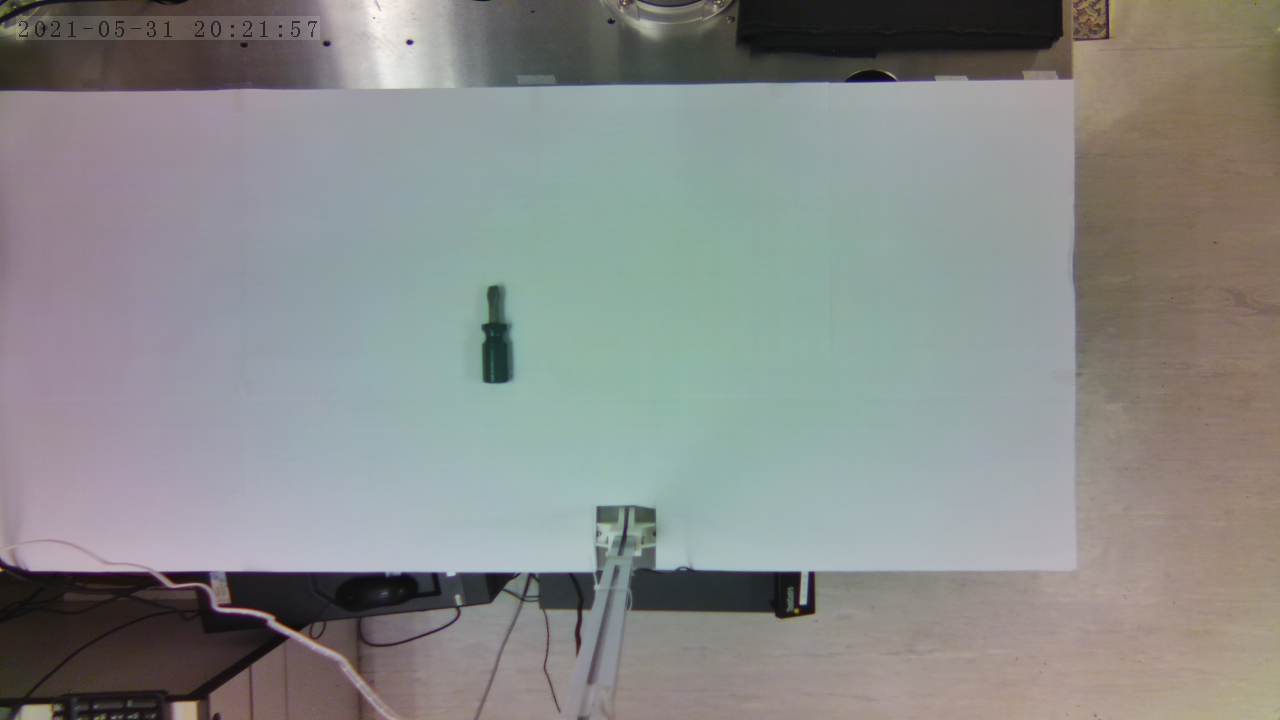

In [ ]:
path_img= path_data+'/images_label_type1/train/img10100r.jpg'

image = tf.keras.preprocessing.image.load_img(path_img)
tf.keras.preprocessing.image.array_to_img(image, data_format=None, scale=True, dtype=None)


## Load pictures in the folder and export as array pickcles
#### disable it if you already have the pickcle data

In [ ]:
'''
import os

datapath = path_data

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

ext= '.jpg' #('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))

for folder in os.listdir(datapath):

  print(folder)
  subfolderpath = datapath+folder
  for subfolder in os.listdir(subfolderpath):
    #print(subfolder)
    try:
      subfolder2path = subfolderpath+'/'+subfolder
      for ifile in os.listdir(subfolder2path):
        if subfolder=='train':
          xlst = x_train
          ylst = y_train
        elif subfolder=='val':
          xlst = x_val
          ylst = y_val       
        elif subfolder=='test':
          xlst = x_test
          ylst = y_test       

        filepath = subfolder2path+'/'+ifile
        if filepath.lower().endswith(ext):
          img_arr = picture2array(filepath)
          xlst.append(img_arr)
          labelfilepath = filepath.replace(ext,'_bbox.txt')
          labbel_arr= np.loadtxt(labelfilepath, delimiter=',')
          #print(labbel_arr)
          if (len(labbel_arr.shape))>1:
            labbel_arr = labbel_arr[0]
          else:
            labbel_arr = labbel_arr


          ylst.append(labbel_arr)
    except:
      pass

_x_train = np.asarray(x_train)
_y_train = np.asarray(y_train)

_x_test = np.asarray(x_test)
_y_test = np.asarray(y_test)

_x_val = np.asarray(x_val)
_y_val = np.asarray(y_val)


print(_x_train.shape,_y_train.shape, _x_val.shape,_y_val.shape, _x_test.shape, _y_test.shape,)
'''

"\nimport os\n\ndatapath = path_data\n\nx_train = []\ny_train = []\n\nx_val = []\ny_val = []\n\nx_test = []\ny_test = []\n\next= '.jpg' #('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))\n\nfor folder in os.listdir(datapath):\n\n  print(folder)\n  subfolderpath = datapath+folder\n  for subfolder in os.listdir(subfolderpath):\n    #print(subfolder)\n    try:\n      subfolder2path = subfolderpath+'/'+subfolder\n      for ifile in os.listdir(subfolder2path):\n        if subfolder=='train':\n          xlst = x_train\n          ylst = y_train\n        elif subfolder=='val':\n          xlst = x_val\n          ylst = y_val       \n        elif subfolder=='test':\n          xlst = x_test\n          ylst = y_test       \n\n        filepath = subfolder2path+'/'+ifile\n        if filepath.lower().endswith(ext):\n          img_arr = picture2array(filepath)\n          xlst.append(img_arr)\n          labelfilepath = filepath.replace(ext,'_bbox.txt')\n          labbel_arr= np.loadtxt(labelfilepath,

In [ ]:
'''
#save files as pickle
filename = path_data+'_x_train'
outfile = open(filename,'wb')
pickle.dump(_x_train,outfile)
outfile.close()

filename = path_data+'_y_train'
outfile = open(filename,'wb')
pickle.dump(_y_train,outfile)
outfile.close()

filename = path_data+'_x_test'
outfile = open(filename,'wb')
pickle.dump(_x_test,outfile)
outfile.close()

filename = path_data+'_y_test'
outfile = open(filename,'wb')
pickle.dump(_y_test,outfile)
outfile.close()


filename = path_data+'_x_val'
outfile = open(filename,'wb')
pickle.dump(_x_val,outfile)
outfile.close()

filename = path_data+'_y_val'
outfile = open(filename,'wb')
pickle.dump(_y_val,outfile)
outfile.close()
'''

"\n#save files as pickle\nfilename = path_data+'_x_train'\noutfile = open(filename,'wb')\npickle.dump(_x_train,outfile)\noutfile.close()\n\nfilename = path_data+'_y_train'\noutfile = open(filename,'wb')\npickle.dump(_y_train,outfile)\noutfile.close()\n\nfilename = path_data+'_x_test'\noutfile = open(filename,'wb')\npickle.dump(_x_test,outfile)\noutfile.close()\n\nfilename = path_data+'_y_test'\noutfile = open(filename,'wb')\npickle.dump(_y_test,outfile)\noutfile.close()\n\n\nfilename = path_data+'_x_val'\noutfile = open(filename,'wb')\npickle.dump(_x_val,outfile)\noutfile.close()\n\nfilename = path_data+'_y_val'\noutfile = open(filename,'wb')\npickle.dump(_y_val,outfile)\noutfile.close()\n"

# Data Preprocessing

## Load stored pickle files

In [ ]:
%%time

path= path_data

file = open(path+"_x_train",'rb')
_x_train = pickle.load(file)
file.close()

file = open(path+"_y_train",'rb')
_y_train = pickle.load(file)
file.close()

file = open(path+"_x_val",'rb')
_x_val = pickle.load(file)
file.close()

file = open(path+"_y_val",'rb')
_y_val = pickle.load(file)
file.close()

file = open(path+"_x_test",'rb')
_x_test = pickle.load(file)
file.close()

file = open(path+"_y_test",'rb')
_y_test = pickle.load(file)
file.close()

print(_x_train.shape, _y_train.shape, _x_val.shape,_y_val.shape, _x_test.shape, _y_test.shape,)

(126, 720, 1280, 3) (126, 11) (36, 720, 1280, 3) (36, 11) (36, 720, 1280, 3) (36, 11)
CPU times: user 201 ms, sys: 685 ms, total: 886 ms
Wall time: 7.75 s


## Visulize pickle data

In [ ]:
# num_list = random.sample(range(0, len(_x_train)), 1)

# for num in num_list:
#   print(num)
#   img_arr = _x_train[num]
#   print(img_arr.shape)

#   label =_y_train[num]
#   print(label)

#   imgwbox = draw_bounding_boxes(img_arr, label)

#   pil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)
#   display(tf.keras.preprocessing.
#           image.array_to_img(pil_img))
  

## Crop Images test and display

In [ ]:
# transform_crop = A.Compose([
#     A.Crop(x_min=0, y_min=90, x_max=1050, y_max=560, always_apply=True),
# ], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=True))


# num_list = random.sample(range(0, len(_x_train)), 10)
# num =num_list[0]

# for i in range(1):
#   img_arr = _x_train[num]
#   print(img_arr.shape)

#   label =_y_train[num]
#   label= label[0:8]

#   keypoints = [
#   label
#   ]

#   keypoints = [
#       (label[0], label[1]),
#       (label[2], label[3]),
#       (label[4], label[5]),
#       (label[6], label[7]), 
#   ]

#   transformed_crop = transform_crop(image=img_arr, keypoints=keypoints)
#   transformed_image_crop = transformed_crop['image']
#   transformed_keypoints_crop = transformed_crop['keypoints']
  

#   img = transformed_image_crop
#   pts = np.asarray(transformed_keypoints_crop).flatten()

#   print(label)
#   print(pts)

#   img_aug = draw_bounding_boxes(img,pts,option='box')
#   transformed_img = tf.keras.preprocessing.image.array_to_img(img_aug)
  
#   original_img = tf.keras.preprocessing.image.array_to_img(img_arr)

#   print(img_aug.shape)
#   display(transformed_img)
#   display(original_img)

## Enable cropped image and remove background(optional, off)

In [ ]:

# _x_train_crop = []
# _x_val_crop = []
# _x_test_crop = []

# _y_train_crop = []
# _y_val_crop = []
# _y_test_crop = []


# for i in range(len(_x_train)):
#   img_arr = _x_train[i]
#   #print(img_arr.shape)

#   label =_y_train[i]
#   label= label[0:8]
#   label_class = _y_train[i][8:]

#   keypoints = [
#   label
#   ]

#   keypoints = [
#       (label[0], label[1]),
#       (label[2], label[3]),
#       (label[4], label[5]),
#       (label[6], label[7]), 
#   ]

#   transformed_crop = transform_crop(image=img_arr, keypoints=keypoints)
#   transformed_image_crop = transformed_crop['image']
#   transformed_keypoints_crop = transformed_crop['keypoints']
  
  
#   img = transformed_image_crop
#   pts = np.asarray(transformed_keypoints_crop).flatten()
#   if (len(pts)) >=8:

#     pts = np.append(pts,label_class)
#     _x_train_crop.append(img)
#     _y_train_crop.append(pts)

#   #print(transformed_keypoints_crop)

# _x_train_crop = np.asarray(_x_train_crop)
# _y_train_crop = np.asarray(_y_train_crop)


# for i in range(len(_x_val)):
#   img_arr = _x_val[i]
#   #print(img_arr.shape)

#   label =_y_train[i]
#   label= label[0:8]
#   label_class = _y_train[i][8:]

#   keypoints = [
#   label
#   ]

#   keypoints = [
#       (label[0], label[1]),
#       (label[2], label[3]),
#       (label[4], label[5]),
#       (label[6], label[7]), 
#   ]

#   transformed_crop = transform_crop(image=img_arr, keypoints=keypoints)
#   transformed_image_crop = transformed_crop['image']
#   transformed_keypoints_crop = transformed_crop['keypoints']
  

#   img = transformed_image_crop
#   pts = np.asarray(transformed_keypoints_crop).flatten()
#   if (len(pts)) >=8:

#     pts = np.append(pts,label_class)
#     _x_val_crop.append(img)
#     _y_val_crop.append(pts)

# _x_val_crop = np.asarray(_x_val_crop)
# _y_val_crop = np.asarray(_y_val_crop)

# for i in range(len(_x_test)):
#   img_arr = _x_test[i]
#   #print(img_arr.shape)

#   label =_y_train[i]
#   label= label[0:8]
#   label_class = _y_train[i][8:]

#   keypoints = [
#   label
#   ]

#   keypoints = [
#       (label[0], label[1]),
#       (label[2], label[3]),
#       (label[4], label[5]),
#       (label[6], label[7]), 
#   ]

#   transformed_crop = transform_crop(image=img_arr, keypoints=keypoints)
#   transformed_image_crop = transformed_crop['image']
#   transformed_keypoints_crop = transformed_crop['keypoints']
  

#   img = transformed_image_crop
#   pts = np.asarray(transformed_keypoints_crop).flatten()
#   if (len(pts)) >=8:
    
#     pts = np.append(pts,label_class)
#     _x_test_crop.append(img)
#     _y_test_crop.append(pts)

# _x_test_crop = np.asarray(_x_test_crop)
# _y_test_crop = np.asarray(_y_test_crop)

# print(_x_train_crop.shape,_y_train_crop.shape, _x_val_crop.shape,_y_val_crop.shape, _x_test_crop.shape,_y_test_crop.shape )


# _x_train =_x_train_crop
# _y_train = _y_train_crop
# _x_val = _x_val_crop
# _y_val = _y_val_crop
# _x_test = _x_test_crop
# _y_test = _y_test_crop 

# print(_x_train.shape,_y_train.shape, _x_val.shape,_y_val.shape, _x_test.shape,_y_test.shape )


## Create data augmentation function

In [ ]:
transform = A.Compose([
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=[-0.0625,0.0625], scale_limit=[0.1,0.5], rotate_limit=[-45,45], p=0.5),
    A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=0.1),
    A.HueSaturationValue(hue_shift_limit=[-20,20], sat_shift_limit=[-20,20], val_shift_limit=[-20,20], p=0.3),
    A.RGBShift(r_shift_limit=[-40,40], g_shift_limit=[-40,40], b_shift_limit=[-40,40], p=0.3),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
    ], p=0.2),
    #A.RandomGamma(p=0.2),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.3),
    #A.RandomResizedCrop(300,300),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=True, remove_invisible=True  ))


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


## Test and visulize augmentation function

In [ ]:
# num_list = random.sample(range(0, len(_x_train)), 1)
# num =num_list[0]

# for i in range(10):
  
#   img_arr = _x_train[num]
#   print(img_arr.shape)

#   label =_y_train[num]
#   label= label[0:8]

#   keypoints = [
#   label
#   ]

#   keypoints = [
#       (label[0], label[1]),
#       (label[2], label[3]),
#       (label[4], label[5]),
#       (label[6], label[7]), 
#   ]

#   transformed = transform(image=img_arr, keypoints=keypoints)
#   transformed_image = transformed['image']
#   transformed_keypoints = transformed['keypoints']
  

#   img = transformed_image
#   pts = np.asarray(transformed_keypoints).flatten()
#   print(pts)
#   try:
#     img_aug = draw_bounding_boxes(img,pts,option='box')
#     transformed_img = tf.keras.preprocessing.image.array_to_img(img_aug)
#     print(img_aug.shape)
#     display(transformed_img)
#   except:
#     print('bbox out of picture after shift and rotatation')
#     transformed_img = tf.keras.preprocessing.image.array_to_img(transformed_image)
#     print(img_aug.shape)
#     display(transformed_img)   

#     pass


## Create augmentation image and labels

In [ ]:
%%time
augbum = 25
_x_train_aug = []
_y_train_aug = []

for i in range(len(_x_train)):
  for j in range(augbum):
    try:
      img_arr = _x_train[i]
      #print(img_arr.shape)
      label= _y_train[i][0:8]
      label_class = _y_train[i][8:]

      keypoints = [
      label
      ]

      keypoints = [
          (label[0], label[1]),
          (label[2], label[3]),
          (label[4], label[5]),
          (label[6], label[7]), 
      ]

      transformed = transform(image=img_arr, keypoints=keypoints)
      transformed_image = transformed['image']
      transformed_keypoints = transformed['keypoints']
      
      img = transformed_image
      pts = np.asarray(transformed_keypoints).flatten()
      #print(pts)
      img_aug = draw_bounding_boxes(img,pts)
      transformed_img = tf.keras.preprocessing.image.array_to_img(img_aug)
      #print(img_aug.shape)

      #if j == 0 and i%20 == 0:
      #  display(transformed_img)

      #print(img)
      #print(pts)
      new_path = '/content/drive/MyDrive/grasp_share/Alan/20210531_grasp_dataset_ver3/images_label_new/'

      #save onto the drive
      '''
      im = Image.fromarray(img)
      im.save(new_path+str(i)+'_'+str(j)+'aug.jpg')

      lab_aug = np.append(pts,label_class)
      np.savetxt(new_path+str(i)+'_'+str(j)+'aug.txt', lab_aug, newline=',') 
      '''


      if len(pts)>=8:
      
        lab_aug = np.append(pts,label_class)
        
        _x_train_aug.append(img)
        _y_train_aug.append(lab_aug)
      else:
        #print(len(pts))
        pass

    except:
      pass

_x_train_aug = np.asarray(_x_train_aug)
_y_train_aug = np.asarray(_y_train_aug)

print(_x_train_aug.shape,_y_train_aug.shape)

#_x_train = _x_train_aug
#_y_train = _y_train_aug 

_x_train = np.concatenate((_x_train, _x_train_aug), axis=0)
_y_train = np.concatenate((_y_train, _y_train_aug), axis=0)

print(_x_train.shape,_y_train.shape)


(3003, 720, 1280, 3) (3003, 11)
(3129, 720, 1280, 3) (3129, 11)
CPU times: user 3min 24s, sys: 21.3 s, total: 3min 45s
Wall time: 2min 35s


## Transform the data from 4 points to yolo format (x,y,w,h) (Optional,ON)

In [ ]:
_y_train = Fourpts2yolo(_y_train)
_y_val = Fourpts2yolo(_y_val)
_y_test = Fourpts2yolo(_y_test)

print(_x_train.shape, _y_train.shape, _x_val.shape,_y_val.shape, _x_test.shape, _y_test.shape,)

print('==================================================')
print(_y_train[:,2].min(),_y_train[:,2].max())
print(_y_val[:,2].min(),_y_val[:,2].max())
print(_y_test[:,2].min(),_y_test[:,2].max())
print('==================================================')
print(_y_train[:,3].min(),_y_train[:,3].max())
print(_y_val[:,3].min(),_y_val[:,3].max())
print(_y_test[:,3].min(),_y_test[:,3].max())
print('==================================================')
print(_y_train[:,4].min(),_y_train[:,4].max())
print(_y_val[:,4].min(),_y_val[:,4].max())
print(_y_test[:,4].min(),_y_test[:,4].max())


(3129, 720, 1280, 3) (3129, 8) (36, 720, 1280, 3) (36, 8) (36, 720, 1280, 3) (36, 8)
17.760299999999976 73.58463125499594
18.500000000000007 44.500000000000014
14.751849999999957 46.00000000000001
7.327450000000005 23.27488093143766
9.49999999999998 16.91739999999999
8.321349999999994 16.061199999999964
0.0 180.0
8.597575490615071 180.0
4.206598836070981 180.0


## Combine valdation and test data(optional, ON)

In [ ]:
_x_val = np.concatenate((_x_val, _x_test), axis=0)
_y_val = np.concatenate((_y_val, _y_test), axis=0)

print(_x_val.shape,_y_val.shape)

(72, 720, 1280, 3) (72, 8)


## Data normalization and rescaling

In [ ]:
width=224
height =224

width_xaxis=1280
height_yaxis=760

#width_box_range= [15,80]
#height_box_range=[5,30]

width_box_max = 80 
height_box_max = 30

angle_max=180

#====================train==================

num_list = random.sample(range(0, len(_x_test)), 1)
num = num_list[0]

print(_x_train[num][0][0])
images_arr_resize =  tf.image.resize(_x_train, [height, width])
images_arr_resize_nor= images_arr_resize/255
x_train = tf.convert_to_tensor(images_arr_resize_nor)
print(x_train[num][0][0])


print(_y_train[num]) 
label_r= PreprocessLabel(_y_train, width_xaxis=width_xaxis, height_yaxis= height_yaxis , width_box_max= width_box_max, height_box_max=height_box_max, angle_max=angle_max )
y_train = tf.convert_to_tensor(label_r)
print(y_train[num]) 


#====================val==================
print(_x_val[num][0][0])
images_arr_resize =  tf.image.resize(_x_val, [height, width])
images_arr_resize_nor= images_arr_resize/255
x_val = tf.convert_to_tensor(images_arr_resize_nor)
print(x_val[num][0][0])


print(_y_val[num]) 
label_r= PreprocessLabel(_y_val, width_xaxis=width_xaxis, height_yaxis= height_yaxis , width_box_max= width_box_max, height_box_max=height_box_max, angle_max=angle_max )
y_val = tf.convert_to_tensor(label_r)
print(y_val[num]) 


#====================test==================
x_test = _x_test
y_test = _y_test

print(x_train.shape, y_train.shape, x_val.shape,y_val.shape, x_test.shape, y_test.shape,)

print('==================================================')
print(y_train[:,2].numpy().min(),y_train[:,2].numpy().max())
print(y_val[:,2].numpy().min(),y_val[:,2].numpy().max())
print(y_test[:,2].min(),y_test[:,2].max())
print('==================================================')
print(y_train[:,3].numpy().min(),y_train[:,3].numpy().max())
print(y_val[:,3].numpy().min(),y_val[:,3].numpy().max())
print(y_test[:,3].min(),y_test[:,3].max())
print('==================================================')
print(y_train[:,4].numpy().min(),y_train[:,4].numpy().max())
print(y_val[:,4].numpy().min(),y_val[:,4].numpy().max())
print(y_test[:,4].min(),y_test[:,4].max())


[49 46 39]
tf.Tensor([0.10748299 0.0887355  0.17433973], shape=(3,), dtype=float32)
[534.2345 346.6416  30.5      9.5    180.       0.       1.       0.    ]
tf.Tensor(
[0.4173707  0.45610737 0.38125    0.31666667 1.         0.
 1.         0.        ], shape=(8,), dtype=float64)
[52 57 60]
tf.Tensor([0.10871349 0.08323329 0.18093236], shape=(3,), dtype=float32)
[459.7345     371.1416      26.          11.          42.58594756
   1.           0.           0.        ]
tf.Tensor(
[0.35916758 0.48834421 0.325      0.36666667 0.2365886  1.
 0.         0.        ], shape=(8,), dtype=float64)
(3129, 224, 224, 3) (3129, 8) (72, 224, 224, 3) (72, 8) (36, 720, 1280, 3) (36, 8)
0.22200374999999972 0.9198078906874493
0.18439812499999947 0.5750000000000001
14.751849999999957 46.00000000000001
0.2442483333333335 0.7758293643812554
0.2773783333333331 0.563913333333333
8.321349999999994 16.061199999999964
0.0 1.0
0.023369993533727672 1.0
4.206598836070981 180.0


## Test inverse label function


In [ ]:
# num_list = random.sample(range(0, len(_x_train)), 3)

# for num in num_list:
#   print(num)
#   img_arr = _x_train[num:num+1]
#   print(img_arr.shape)

#   print(y_train[num:num+1])
#   label = InvNorLabel(y_train[num:num+1], 
#                       width_xaxis=width_xaxis, height_yaxis=height_yaxis, 
#                       width_box_max = width_box_max, height_box_max= height_box_max, 
#                       angle_max=angle_max)
#   print(label)
#   imgwbox = draw_bounding_boxes(img_arr[0], label[0])
#   pil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)
#   display(tf.keras.preprocessing.image.array_to_img(pil_img))


# Model construction

## Define model shape

In [ ]:
HEIGHT = height
WIDTH = width
NUM_CHANNELS = x_train.shape[3]
output_size = y_train.shape[1]
input_shape=(height, width, NUM_CHANNELS)

## Reference model(optional)

In [ ]:
# def create_model_Alexnet():
#   # Instantiate an empty sequential model
#   model = Sequential(name="Alexnet")
#   # 1st layer (conv + pool + batchnorm)
#   model.add(layers.Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', kernel_regularizer=tf.keras.regularizers.L2(0.0005),
#   input_shape = (height, width, NUM_CHANNELS)))
#   model.add(layers.Activation('elu'))  #<---- activation function can be added on its own layer or within the Conv2D function
#   model.add(layers.MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
#   model.add(layers.BatchNormalization())
      
#   # 2nd layer (conv + pool + batchnorm)
#   model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
#   model.add(layers.Activation('elu'))
#   model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
#   model.add(layers.BatchNormalization())
              
#   # layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
#   model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
#   model.add(layers.Activation('elu'))
#   model.add(layers.BatchNormalization())
          
#   # layer 4 (conv + batchnorm)      <--- similar to layer 3
#   model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
#   model.add(layers.Activation('relu'))
#   model.add(layers.BatchNormalization())
              
#   # layer 5 (conv + batchnorm)  
#   model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
#   model.add(layers.Activation('elu'))
#   model.add(layers.BatchNormalization())
#   model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='elu'))

#   # Flatten the CNN output to feed it with fully connected layers
#   model.add(layers.Flatten())

#   # layer 6 (Dense layer + dropout)  
#   model.add(layers.Dense(units = 4096, activation = 'elu'))
#   model.add(layers.Dropout(0.5))

#   # layer 7 (Dense layers) 
#   model.add(layers.Dense(units = 4096, activation = 'elu'))
#   model.add(layers.Dropout(0.5))
                            
#   # layer 8 (softmax output layer) 
#   model.add(layers.Dense(units = output_size, activation = 'sigmoid'))

#   # print the model summary
#   return model


# def create_model_simple():

#   model = Sequential([
#     layers.experimental.preprocessing.Rescaling(1./1, input_shape=(height, width, NUM_CHANNELS)),
#     layers.Conv2D(16, 3, padding='same', activation='elu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='elu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='elu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='elu'),
#     layers.Dense(output_size, activation='sigmoid')
#   ])
#   return model

# def create_model_Lenet():
  
#   model = Sequential([
#     layers.experimental.preprocessing.Rescaling(1./1, input_shape=(height, width, NUM_CHANNELS)),
#     layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="same"),
#     layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
#     layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
#     layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
#     layers.Flatten(),
#     layers.Dense(120, activation='tanh'),
#     layers.Dense(84, activation='tanh'),
#     layers.Dense(output_size, activation='sigmoid'),
#   ])
#   return model

# model2 = create_model_Lenet()
# model2.summary()


## Define pretrained model( transfer learning)

In [ ]:
# #! model
# def create_model():
#   #VGG19,ResNet50V2,ResNet152V2,MobileNetV3Small,DenseNet121,InceptionResNetV2,InceptionV3
#   base_model = tf.keras.applications.InceptionResNetV2(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False)
#   #base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=None, input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))
#   print(len(base_model.layers))
#   target_layers_num = len(base_model.layers)
#   for i in range(len(base_model.layers)-1,0,-1):
#     train_layer_num = len(base_model.layers) - target_layers_num
#     if i> (train_layer_num) :
#       #if not isinstance(base_model.layers[i], tf.keras.layers.BatchNormalization):
#       #  base_model.layers[i].trainable = True
#       base_model.layers[i].trainable = True
#     else:
#       base_model.layers[i].trainable = False

#   x = base_model.output
#   x = layers.GlobalAveragePooling2D()(x)
#   # x = layers.Dropout(0.5)(x)
#   # x = layers.Dense(512, activation='relu',kernel_regularizer= tf.keras.regularizers.l2(0.001))(x)
#   # x = layers.Dropout(0.5)(x)
#   x = layers.Dense(output_size)(x)

#   model = models.Model(inputs=base_model.input, outputs=x)
#   return model

# model = create_model()
# model.summary()

In [ ]:
#! model
def create_model():
  #VGG19,ResNet50V2,ResNet152V2,MobileNetV3Small,DenseNet121,InceptionResNetV2,InceptionV3
  base_model = tf.keras.applications.InceptionResNetV2(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False)
  #base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=None, input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))
  print(len(base_model.layers))

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  # x = layers.Dropout(0.5)(x)
  # x = layers.Dense(512, activation='elu')(x)
  # x = layers.Dropout(0.5)(x)
  x = layers.Dense(output_size)(x)

  model = models.Model(inputs=base_model.input, outputs=x)
  return model

model = create_model()
model.summary()

780
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

## Test the model inference

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.06173252,  0.7281009 ,  1.2061414 ,  0.21711126, -0.7749806 ,
        -2.370043  ,  0.35369337,  0.45556986]], dtype=float32)

# Model Training

## Define callbacks

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      #y_pred = self.model.predict(self.validation_data[0])
      #print('prediction: {} at epoch: {}'.format(y_pred, epoch))
      keys = list(logs.keys())
      print("End epoch {} of training; got log keys: {}".format(epoch, keys))
  

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

stopper_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=10, verbose=1, mode='auto',
                              min_delta=0.0001, cooldown=0, min_lr=1e-8)

print_callback= CustomCallback()

## Define custom loss function

In [ ]:
@tf.function
def _yolo2corner(boxes):
  return tf.concat([boxes[..., :2] - boxes[..., 2:4] / 2.0, boxes[..., :2] + boxes[..., 2:4] / 2.0], axis=-1)

@tf.function
def compute_iou(y_true, y_pred):
  '''
  y_true, y_pred format: yolo ---> [x, y, w, h, theta]
  '''
  y_true_cor = _yolo2corner(y_true)
  y_pred_cor = _yolo2corner(y_pred)

  interMin = tf.maximum(y_true_cor[:, :2], y_pred_cor[:, :2])
  interMax = tf.minimum(y_true_cor[:, 2:], y_pred_cor[:, 2:])
  intersection = tf.maximum(0.0, interMax - interMin)
  interArea = tf.multiply(intersection[:, 0], intersection[:, 1])

  trueArea = tf.multiply(y_true[:, 2], y_true[:, 3])
  predArea = tf.multiply(y_pred[:, 2], y_pred[:, 3])
  unionArea = tf.maximum(
        trueArea + predArea - interArea, 1e-8
    )
  
  return tf.clip_by_value(interArea / unionArea, 0.0, 1.0)

In [ ]:
@tf.function
def custom_error(y_true, y_pred):
    if y_pred.shape[1] == 8:
      xy_loss = tf.keras.losses.MSE(y_true[:,0:2],y_pred[:,0:2])
      xy_loss = 5 * xy_loss
      wh_loss = tf.keras.losses.MSE(y_true[:,2:4],y_pred[:,2:4])
      angle_loss = tf.keras.losses.MSE(y_true[:,4:5], y_pred[:,4:5])
      angle_loss = angle_loss * 0.1
      class_loss = tf.keras.losses.categorical_crossentropy(y_true[:,5:8],y_pred[:,5:8],from_logits=True ) # doesnt work when it is combined with mse loss
      class_loss = class_loss * 0.01
      class_acc = tf.keras.metrics.categorical_accuracy(y_true[:,5:8],y_pred[:,5:8])
      iou_loss = 1 - compute_iou(y_true, y_pred)
      iou_loss = iou_loss * 0.3
      total_loss = xy_loss + wh_loss + class_loss + angle_loss + iou_loss

    else:
      xy_loss = tf.keras.losses.MSE(y_true[:,0:8],y_pred[:,0:8]) 
      class_loss = tf.keras.losses.categorical_crossentropy(y_true[:,8:11], y_pred[:,8:11],from_logits=True)
      class_acc = tf.kearas.metrics.categorical_accuracy(y_true[:,5:],y_pred[:,5:],from_logits=True )
      wh_loss = xy_loss
      angle_loss = xy_loss
      total_loss = xy_loss + class_loss

    return total_loss 

## Train the model

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

opt = tf.keras.optimizers.Nadam(learning_rate=0.0003)
model = create_model()
#model = create_model_simple()
#model = create_model_Lenet()
#model = create_model_Alexnet()

model.compile(optimizer = opt,
              loss= custom_error,
              #metrics=["mean_absolute_error"]
              )

#model.fit(x=x_train, y=y_train, epochs=1000, validation_split=0.2, callbacks=[tensorboard_callback,stopper_callback], batch_size=32, shuffle=True)
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), 
                    callbacks=[tensorboard_callback, stopper_callback, reduceLR_callback],
                    batch_size=64, epochs=2000, shuffle=True)
        

780
Epoch 1/2000
49/49 [==============================] - 94s 819ms/step - loss: 0.4975 - val_loss: 0.6620
Epoch 2/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.2003 - val_loss: 0.2432
Epoch 3/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1556 - val_loss: 0.3732
Epoch 4/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1468 - val_loss: 0.2240
Epoch 5/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1311 - val_loss: 0.1914
Epoch 6/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1237 - val_loss: 0.1471
Epoch 7/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1222 - val_loss: 0.1452
Epoch 8/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1180 - val_loss: 0.3379
Epoch 9/2000
49/49 [==============================] - 31s 639ms/step - loss: 0.1079 - val_loss: 0.1482
Epoch 10/2000
49/49 [==============================] - 31s 639ms/step

KeyboardInterrupt: ignored

In [ ]:
# Load the TensorBoard notebook extension.
#!kill 2092
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
myfolder = '/content/drive/MyDrive/DLOD'
save_path = myfolder+ '/model_'+'6.18_noFCLayers_9_1(Good)'+'/'
tf.saved_model.save(model, save_path)

# for .om file
convert_to_froze_graph(keras_model= model, 
                       model_name='pb2OMfile.pb', 
                       output_folder=save_path)

# Model testing

## Run model with train dataset

In [ ]:
num_list = random.sample(range(0, len(_x_train)), 10)

for num in num_list:
  print(num)
  img_arr = _x_train[num:num+1]
  print(img_arr.shape)
  input = preprocessImg(img_arr, height =height, width=width)
  print(input.shape)

  output = model(input, training=False)
  print(output)
  print(y_train[num:num+1])

  pred = InvNorLabel(output, 
                      width_xaxis=width_xaxis, height_yaxis=height_yaxis, 
                      width_box_max = width_box_max, height_box_max= height_box_max, 
                      angle_max=angle_max)

  label = InvNorLabel(y_train[num:num+1],
                       
                      width_xaxis=width_xaxis, height_yaxis=height_yaxis, 
                      width_box_max = width_box_max, height_box_max= height_box_max, 
                      angle_max=angle_max)


  print(pred)
  print(label)

  imgwbox = draw_bounding_boxes(img_arr[0], pred[0])

  pil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)
  display(tf.keras.preprocessing.image.array_to_img(pil_img))
  #test =[display(tf.keras.preprocessing.image.array_to_img(imgwbox[i])) for i in range(len(imgwbox))]

Output hidden; open in https://colab.research.google.com to view.

## Run model with val dataset

In [ ]:
num_list = random.sample(range(0, len(x_val)), 10)

for num in num_list:
  print(num)
  img_arr = _x_val[num:num+1]
  print(img_arr.shape)
  input = preprocessImg(img_arr, height =height, width=width)
  print(input.shape)

  output = model(input, training=False)


  pred = InvNorLabel(output, 
                      width_xaxis=width_xaxis, height_yaxis=height_yaxis, 
                      width_box_max = width_box_max, height_box_max= height_box_max, 
                      angle_max=angle_max)

  label = InvNorLabel(y_val[num:num+1],
                       
                      width_xaxis=width_xaxis, height_yaxis=height_yaxis, 
                      width_box_max = width_box_max, height_box_max= height_box_max, 
                      angle_max=angle_max)

  print(pred[0])

  imgwbox = draw_bounding_boxes(img_arr[0], pred[0])

  pil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)
  display(tf.keras.preprocessing.image.array_to_img(pil_img))
  #test =[display(tf.keras.preprocessing.image.array_to_img(imgwbox[i])) for i in range(len(imgwbox))]

Output hidden; open in https://colab.research.google.com to view.

## Run model with test dataset

In [ ]:

num_list = random.sample(range(0, len(_x_test)), 10)
for num in num_list:
  print(num)
  img_arr = _x_test[num:num+1]
  print(img_arr.shape)
  input = preprocessImg(img_arr, height =height, width=width)
  print(input.shape)

  output = model(input, training=False)

  pred = InvNorLabel(output, 
                      width_xaxis=width_xaxis, height_yaxis=height_yaxis, 
                      width_box_max = width_box_max, height_box_max= height_box_max, 
                      angle_max=angle_max)


  print(pred)

  imgwbox = draw_bounding_boxes(img_arr[0], pred[0])

  pil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)
  display(tf.keras.preprocessing.image.array_to_img(pil_img))


# Model saving

## Save the model

In [ ]:
'''
%%time
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
ext='all_good_xywha_first_time_inceptionResnet_full_layers'
path_save = '/content/drive/MyDrive/'
path_save = '/content/drive/MyDrive/Colab Notebooks'
tf.saved_model.save(model, save_path)

# for .om file
convert_to_froze_graph(keras_model= model, 
                       model_name='pb2OMfile.pb', 
                       output_folder=save_path)

'''

'\n%%time\n# datetime object containing current date and time\nnow = datetime.now()\ndt_string = now.strftime("%Y_%m_%d_%H_%M_%S")\next=\'all_good_xywha_first_time_inceptionResnet_full_layers\'\npath_save = \'/content/drive/MyDrive/\'\npath_save = \'/content/drive/MyDrive/Colab Notebooks\'\ntf.saved_model.save(model, save_path)\n\n# for .om file\nconvert_to_froze_graph(keras_model= model, \n                       model_name=\'pb2OMfile.pb\', \n                       output_folder=save_path)\n\n'

## Load saved model

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import random
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\nimport tensorflow as tf\nimport random\n"

In [ ]:
'''
save_path = '/content/drive/MyDrive/Colab Notebooks/model_all_good_xywha_first_time_22021_06_10_20_34_08_inceptionREstnet'
model = tf.saved_model.load(save_path, tags=None, options=None)
'''

"\nsave_path = '/content/drive/MyDrive/Colab Notebooks/model_all_good_xywha_first_time_22021_06_10_20_34_08_inceptionREstnet'\nmodel = tf.saved_model.load(save_path, tags=None, options=None)\n"

In [ ]:
'''
width=224
height =224

width_xaxis=1280
height_yaxis=760

#width_box_range= [15,80]
#height_box_range=[5,30]

width_box_max = 80 
height_box_max = 30

angle_max=180
'''

'\nwidth=224\nheight =224\n\nwidth_xaxis=1280\nheight_yaxis=760\n\n#width_box_range= [15,80]\n#height_box_range=[5,30]\n\nwidth_box_max = 80 \nheight_box_max = 30\n\nangle_max=180\n'

In [ ]:
'''
input_path = '/content/pcd0609r.png'

img_arr = picture2array(input_path)
img_arr = img_arr.reshape(1,img_arr.shape[0],img_arr.shape[1],img_arr.shape[2])

print(img_arr.shape)
input = preprocessImg(img_arr, height =height, width=width)
print(input.shape)

output = model(input, training=False)

pred = InvNorLabel(output, 
                    width_xaxis=640, height_yaxis=480, 
                    width_box_max = width_box_max, height_box_max= height_box_max, 
                    angle_max=angle_max)


print(pred)

imgwbox = draw_bounding_boxes(img_arr[0], pred[0])

pil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)
display(tf.keras.preprocessing.image.array_to_img(pil_img))
'''

"\ninput_path = '/content/pcd0609r.png'\n\nimg_arr = picture2array(input_path)\nimg_arr = img_arr.reshape(1,img_arr.shape[0],img_arr.shape[1],img_arr.shape[2])\n\nprint(img_arr.shape)\ninput = preprocessImg(img_arr, height =height, width=width)\nprint(input.shape)\n\noutput = model(input, training=False)\n\npred = InvNorLabel(output, \n                    width_xaxis=640, height_yaxis=480, \n                    width_box_max = width_box_max, height_box_max= height_box_max, \n                    angle_max=angle_max)\n\n\nprint(pred)\n\nimgwbox = draw_bounding_boxes(img_arr[0], pred[0])\n\npil_img = tf.keras.preprocessing.image.array_to_img(imgwbox)\ndisplay(tf.keras.preprocessing.image.array_to_img(pil_img))\n"